In [1]:
# Distributions 
    # T
    # Poisson
    # Negative Binomial 

# Model 
    # Hierarchical regression 

In [2]:
# Wrangling 

    # Retrieve inquiry and corresponding response from company for all rows 
    
    # Convert dates col to datetime type
    
    # Calc response time in mins 
    
    # Select airlines 
    
    # Filter inqueries exceeding 60 mins 
    
    # Generate time attributes 
    
        # Generate response word count 

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
%matplotlib inline 

from IPython.display import Image
!pip install arviz
import arviz as az
import pymc3 as pm 
import scipy 
import scipy.stats as stats 
import scipy.optimize as opt
import statsmodels.api as sm 
from sklearn import preprocessing 
import theano.tensor as tt

%matplotlib inline 
plt.style.use('ggplot')
colors = ['#373854', '#493267', '#9e379f', '#e86af0', '#7bb3ff',
         '#3bd6c6', '#40e0d0', '#43e8d8', '#89ecda', '#b3ecec']

     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 43.4MB/s 
     |████████████████████████████████| 307kB 41.9MB/s 


In [4]:
df = pd.read_csv('../input/twcs/twcs.csv')

In [5]:
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [6]:
# Corresponding responses to tweet id

first_inbound = df[pd.isnull(df.in_response_to_tweet_id) & df.inbound]

# Merge

df = pd.merge(first_inbound, df, left_on = 'tweet_id', right_on = 'in_response_to_tweet_id')
df = df[df.inbound_y ^ True]

# New df

df = df[['author_id_x', # tweeter id 
       'created_at_x', # inbound tweet date
       'text_x',
        'author_id_y', # airline id
        'created_at_y', # response date
        'text_y']]

# Datetime

df['created_at_x'] = pd.to_datetime(df['created_at_x'], 
                                    format = '%a %b %d %H:%M:%S +0000 %Y')

df['created_at_y'] = pd.to_datetime(df['created_at_y'], 
                                    format = '%a %b %d %H:%M:%S +0000 %Y')

# Calc time between outbound response and inbound msg
    # i.e. response speed 
    
df['res_time'] = df['created_at_y'] - df['created_at_x']

# Convert time to mins

df['res_time'] = df['res_time'].astype('timedelta64[s]') / 60

# Exclude > 60 mins 

df = df.loc[df['res_time'] <= 60]

In [7]:
df.res_time.describe()

count    501970.000000
mean         15.676356
std          14.807117
min           0.000000
25%           4.216667
50%          10.033333
75%          23.050000
max          60.000000
Name: res_time, dtype: float64

In [8]:
# Select airlines

df = df[(df.author_id_y == 'Delta') 
        | (df.author_id_y == 'AmericanAir') 
        | (df.author_id_y == 'SouthwestAir')
       | (df.author_id_y == 'British_Airways')
       | (df.author_id_y == 'AmericanAir')
       | (df.author_id_y == 'AirAsiaSupport')
       | (df.author_id_y == 'VirginAtlantic')
       | (df.author_id_y == 'AlaskaAir')
       | (df.author_id_y == 'VirginAmerica')
       | (df.author_id_y == 'JetBlue')
]

In [9]:
# Time attributes 

df['created_at_y_dayofweek'] = df['created_at_y'].apply(lambda x:x.dayofweek)
df['created_at_y_day_of_week'] = df['created_at_y'].dt.weekday_name
df['created_at_y_day'] = df['created_at_y'].dt.day

df['created_at_y_is_weekend'] = df['created_at_y_dayofweek'].isin([5,6]).apply(lambda x: 1 
                                                                               if x == True 
                                                                               else 0)

In [10]:
# Response word count

df['word_count'] = df.text_y.apply(lambda x: len(str(x).split()))

In [11]:
df.dtypes

author_id_x                         object
created_at_x                datetime64[ns]
text_x                              object
author_id_y                         object
created_at_y                datetime64[ns]
text_y                              object
res_time                           float64
created_at_y_dayofweek               int64
created_at_y_day_of_week            object
created_at_y_day                     int64
created_at_y_is_weekend              int64
word_count                           int64
dtype: object

In [12]:
df.head()

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,res_time,created_at_y_dayofweek,created_at_y_day_of_week,created_at_y_day,created_at_y_is_weekend,word_count
78,115801,2017-10-25 16:02:42,@115802 @AirAsiaSupport Why are you not refund...,AirAsiaSupport,2017-10-25 16:47:02,"@115801 Hi Ashutosh , Could you provide us the...",44.333333,2,Wednesday,25,0,17
90,115818,2016-08-06 01:31:50,@DELTA i booked my flight using delta amex car...,Delta,2016-08-06 01:44:03,"@115818 Glad to check. Pls, DM your confirmati...",12.216667,5,Saturday,6,1,13
139,115882,2017-10-31 21:33:48,@Delta why wasn't earlier flight offered when ...,Delta,2017-10-31 22:27:38,@115882 I'm sorry. The earlier flight may not ...,53.833333,1,Tuesday,31,0,19
140,115883,2017-10-29 15:59:35,"@Delta The ""change flight"" search option on yo...",Delta,2017-10-29 16:56:47,"@115883 I sincerely apologize, our IT team is ...",57.200000,6,Sunday,29,1,22
141,115884,2017-10-31 21:33:27,.@delta this has been my inflight studio exper...,Delta,2017-10-31 22:23:07,"@115884 Oh, no! Please speak to a member of th...",49.666667,1,Tuesday,31,0,16


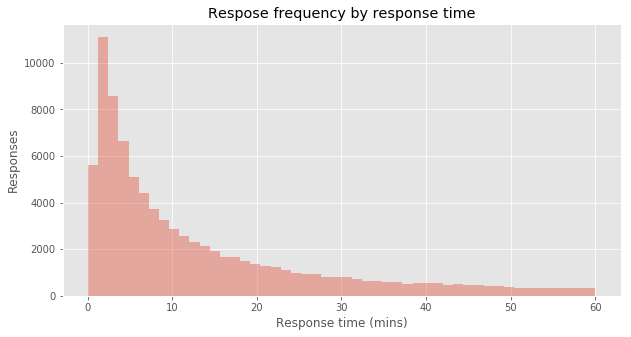

In [13]:
# Response time distribution 

plt.figure(figsize = (10, 5))
sns.distplot(df['res_time'], kde = False)
plt.title('Respose frequency by response time')
plt.xlabel('Response time (mins)')
plt.ylabel('Responses');

In [14]:
# Does not appear Gaussian 
    # Gaussian does not properly describe data 

In [15]:
# T-dist 
    # for managing outliers 
    # replace Gaussian likelihood with t-dist 

# T dist = 3 params 
    # mu 
    # scale (analogous to theta)
    # deg. of freedom

In [16]:
# e = exponential dist with mean of 1 
    # if e = 1, then distribution has heavy tails 
        # more probable to find avlues away from mean 
            # compared to Gaussian dist

with pm.Model() as model_t:
    mu = pm.Uniform('mu', lower = 0, upper = 60) # align with filtered response time  
    sd = pm.HalfNormal('sd', sd = 10)
    e = pm.Exponential('e', 1/1) 
    t = pm.StudentT('t', mu = mu, sd = sd, nu = e, observed = df['res_time'])
    trace = pm.sample(2000, tune = 2000)

Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [01:58<00:00, 67.33draws/s]


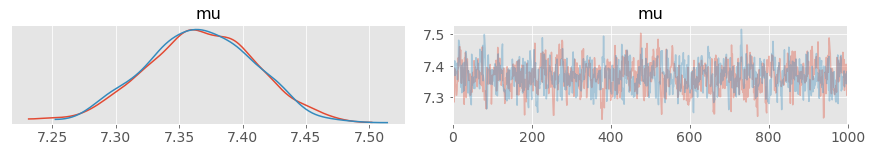

In [17]:
# MCMC (Markov Chain Monte Carlo)
    # see plausible mu from posterior 
    
az.plot_trace(trace[:1000], var_names = ['mu']);

In [18]:
# Credible mu values between 7.3 - 7.5
    # samples drawn from distributions = significantly different from target distribution 

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1108: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:24<00:00, 40.11it/s]


[Text(0, 0.5, 'freq'),
 Text(0.5, 0, 'mean(x)'),
 Text(0.5, 1.0, 'Posterior predictive of the mean')]

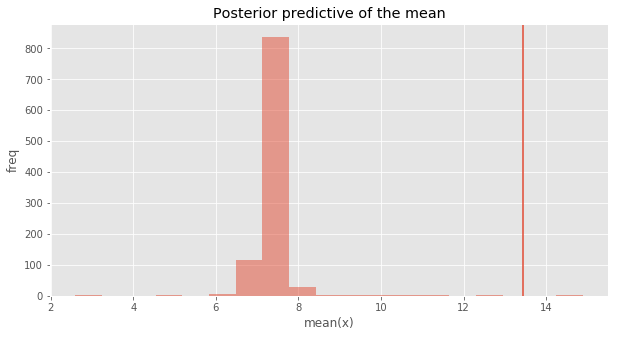

In [19]:
# How close are inferred means to actual sample mean 

# Use ppc to check for systematic discrepancy between real and simulated data 
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = model_t)

_, ax = plt.subplots(figsize = (10, 5))

ax.hist([n.mean() for n in ppc['t']], bins = 19, alpha = 0.5)
ax.axvline(df['res_time'].mean())
ax.set(title = 'Posterior predictive of the mean', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

In [20]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,7.367,0.044,7.289,7.452,0.001,0.001,1316.0,1316.0,1314.0,1612.0,1.0
sd,6.720,0.045,6.636,6.806,0.001,0.001,1234.0,1233.0,1236.0,1838.0,1.0
e,1.675,0.018,1.643,1.709,0.000,0.000,1310.0,1310.0,1310.0,2051.0,1.0


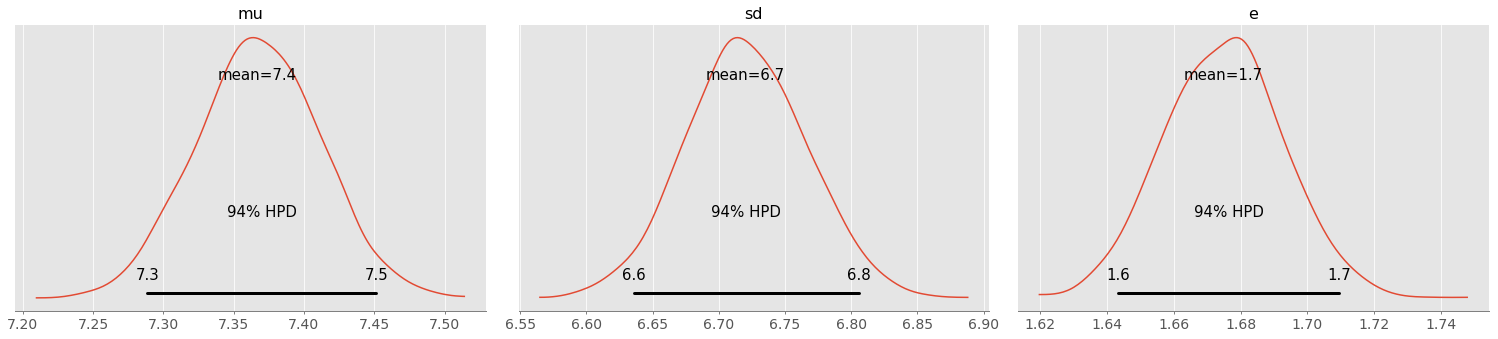

In [21]:
# Highest posterior density 
az.plot_posterior(trace);

In [22]:
df.res_time.mean()

13.436461105326302

In [23]:
# 94% probability of mu / sd / e / between values

# Inferred mean's uncertainty between 7.3 an 7.5
    # far away from actual sample mean of 13.43
    
        # T dist = not a proper choice 

In [24]:
# Poisson dist 
    # describes P(given num of events occuring within a fixed time / space interval)
        # e.g. phone calls within an hour 
        
    # Events are independent 
    
    # Discrete dist parametrized using mu only
        # mu corresponds to mean and var of the dist 

In [25]:
with pm.Model() as model_p:
    mu = pm.Uniform('mu', lower = 0, upper = 60)
    p = pm.Poisson('p', mu = mu, observed = df['res_time'].values)
    trace = pm.sample(2000, tune = 2000)

Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:18<00:00, 433.57draws/s]


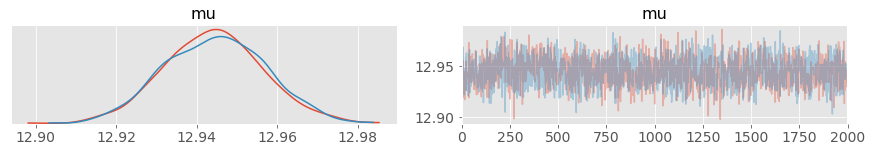

In [26]:
az.plot_trace(trace);

In [27]:
# credible mu between 12.9 - 12.98

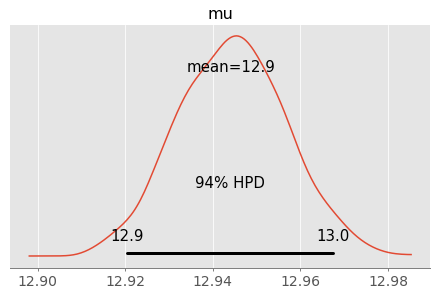

In [28]:
az.plot_posterior(trace);

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1108: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:16<00:00, 60.47it/s]


[Text(0, 0.5, 'freq'),
 Text(0.5, 0, 'mean(x)'),
 Text(0.5, 1.0, 'Posterior predictive of the mean')]

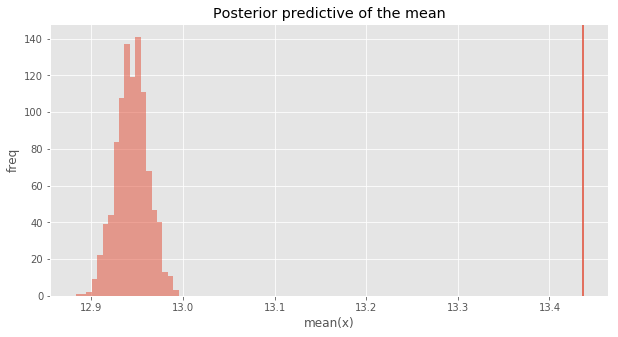

In [29]:
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = model_p)

_, ax = plt.subplots(figsize = (10, 5))

ax.hist([n.mean() for n in ppc['p']], bins = 19, alpha = 0.5)
ax.axvline(df['res_time'].mean())
ax.set(title = 'Posterior predictive of the mean', 
      xlabel = 'mean(x)',
      ylabel = 'freq')

In [30]:
# P dist much closer 
    # Credible mu values between 12.9 - 13.0

az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,12.944,0.012,12.92,12.967,0.0,0.0,1716.0,1716.0,1723.0,2954.0,1.0


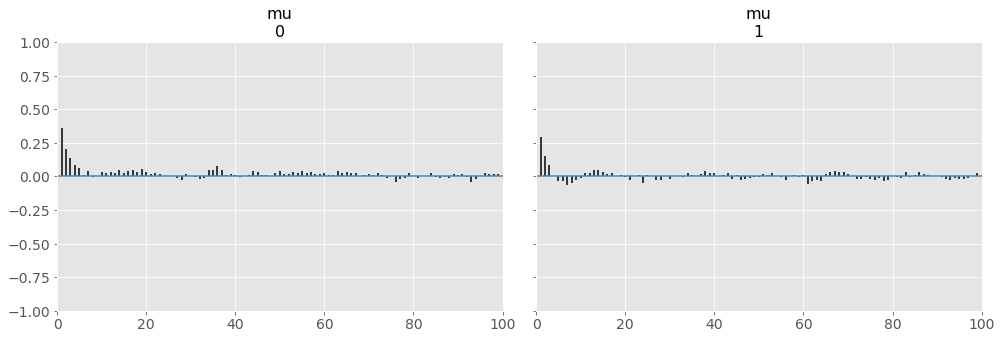

In [31]:
# Autocorrelation 
    # degree of similarity between values of the same variabe over successive time interval 
    
# Ideal = no autocor 
# or samples quickly drop to low autocorr values

_ = pm.autocorrplot(trace, var_names = ['mu'])

# Poisson Autocorrelation decreasing over x-ax

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1108: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:01<00:00, 61.77it/s]


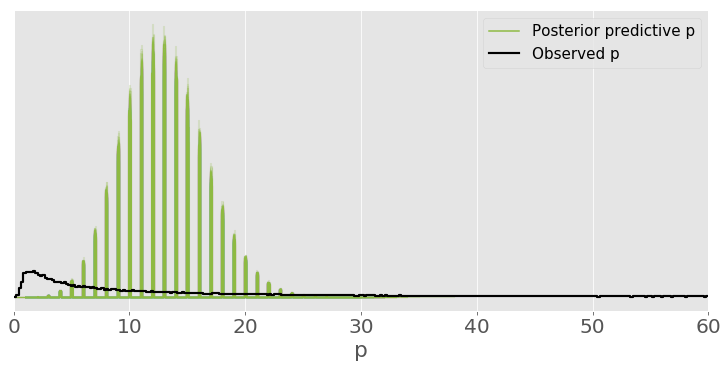

In [32]:
# Poisson ppc 

ppc = pm.sample_posterior_predictive(trace, 100, model_p, random_seed = 150) # 100 posterior predictive samples 

pred = az.from_pymc3(trace = trace, posterior_predictive = ppc)

az.plot_ppc(pred, figsize = (10, 5), mean = False)

plt.xlim(0, 60); 


In [33]:
# Observed p = KDE (kernel density estimate of data)

# Posterior predictive p = KDEs computed from each of 100 posterior predictive samples 
    # reflect uncertainty regarding inferred distribution of predicted data 
    
# Above shows scale of P dist may not be a reasonable proxy for SD of the data even after filtering outliers 

100%|██████████| 1000/1000 [00:16<00:00, 60.32it/s]


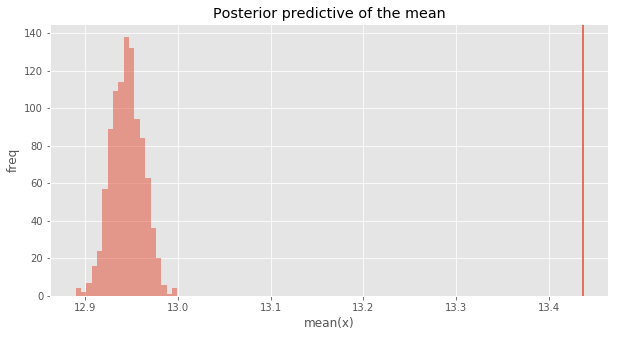

In [34]:
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = model_p)

_, ax = plt.subplots(figsize = (10, 5))

ax.hist([n.mean() for n in ppc['p']], 
        bins = 19, alpha = 0.5)

ax.axvline(df['res_time'].mean())

ax.set(title = 'Posterior predictive of the mean',
      xlabel = 'mean(x)', 
      ylabel = 'freq');

In [35]:
# Small gap between inferred and actual mean 

# Problem: Poisson dist uses same param to describe mean and var 

    # Poisson defined by lambda (rate param)
        # lambda = P(events in time interval)

In [36]:
# Use negative-binomial dist
    # vary var independently of dist mean 
    
# 2 params (mu and alpha)

In [37]:
with pm.Model() as model_n:
    mu = pm.Uniform('mu', lower = 0, upper = 60)
    alpha = pm.Uniform('alpha', lower = 0, upper = 100)
    
    pred = pm.NegativeBinomial('pred', mu = mu, alpha = alpha)
    est = pm.NegativeBinomial('est', mu = mu, alpha = alpha, 
                             observed = df['res_time'].values)
    
    trace = pm.sample(2000, tune = 2000)

Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [03:55<00:00, 25.31draws/s]


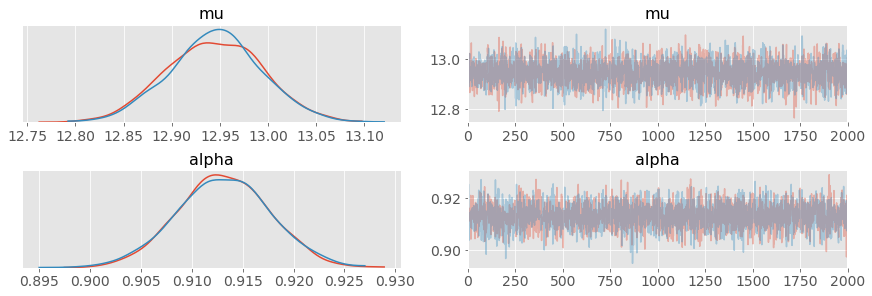

In [38]:
# MCMC
az.plot_trace(trace, var_names = ['mu', 'alpha']);

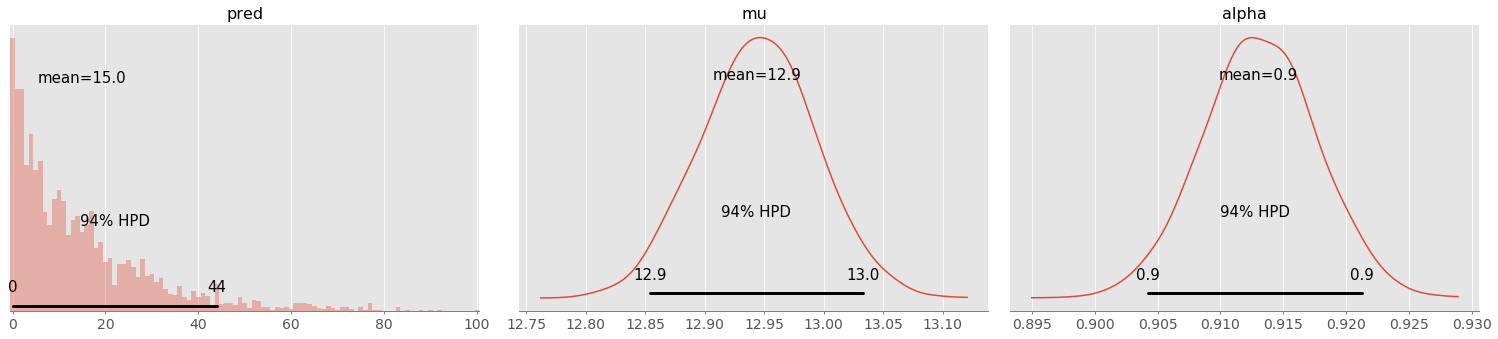

In [39]:
az.plot_posterior(trace);

In [40]:
# credible mu between 12.8 - 13.1

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1108: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:03<00:00, 31.32it/s]


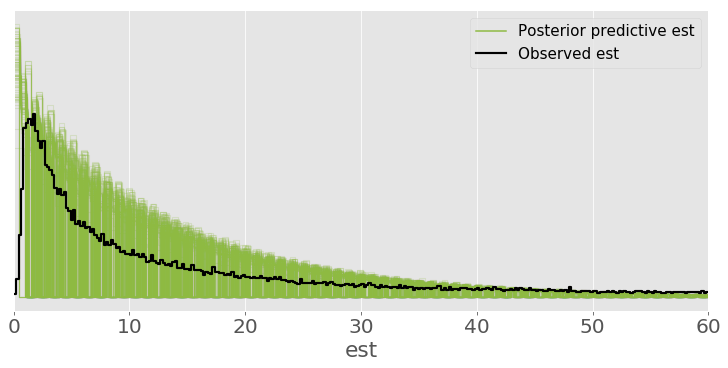

In [41]:
# PPC 

ppc = pm.sample_posterior_predictive(trace, 100, model_n, random_seed = 150) # 100 posterior predictive samples 

pred = az.from_pymc3(trace = trace, posterior_predictive = ppc)

az.plot_ppc(pred, figsize = (10, 5), mean = False)

plt.xlim(0, 60); 

In [42]:
# Uncertainty around inferred distribution reflects kde nicely

100%|██████████| 1000/1000 [00:32<00:00, 31.02it/s]


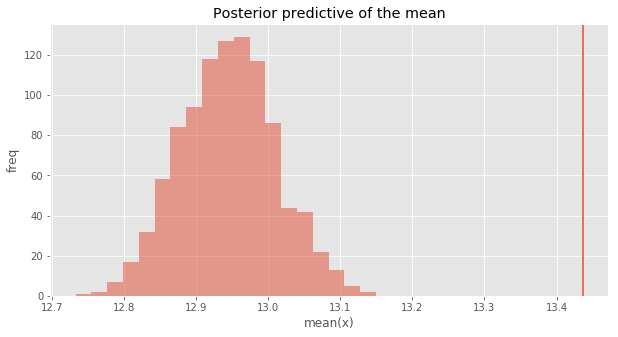

In [43]:
ppc = pm.sample_posterior_predictive(trace, samples = 1000, model = model_n)

_, ax = plt.subplots(figsize = (10, 5))

ax.hist([n.mean() for n in ppc['est']], 
        bins = 19, alpha = 0.5)

ax.axvline(df['res_time'].mean())

ax.set(title = 'Posterior predictive of the mean',
      xlabel = 'mean(x)', 
      ylabel = 'freq');

In [44]:
# More closer than Poisson

# Credible mu between 12.8 - 13.1

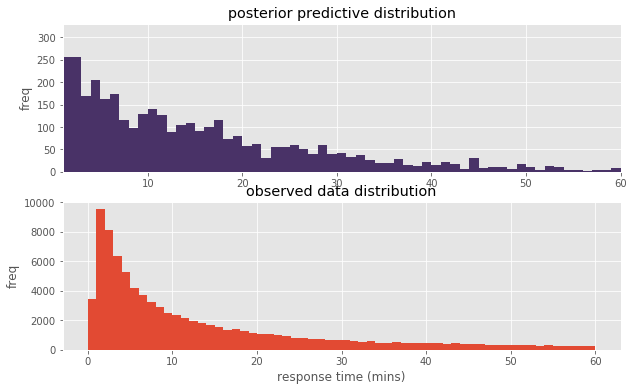

In [45]:
# Posterior predictive dist 

x_lim = 60

pred = trace.get_values('pred')
mu = trace.get_values('mu').mean()

fig = plt.figure(figsize = (10, 6))
fig.add_subplot(211)

_ = plt.hist(pred, range = [0, x_lim], bins = x_lim, color = colors[1])
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('freq')
_ = plt.title('posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(df['res_time'].values, range =[0, x_lim], bins = x_lim)
_ = plt.xlabel('response time (mins)')
_ = plt.ylabel('freq')
_ = plt.title('observed data distribution')

In [46]:
# Posterior for negative binomial somewhat resembles observed 
    # compare with others 

In [47]:
# Bayesian methods for hierarchical modelling / multilevel model

    # Study each airline as a separated entity
    
    # Estimate res_time of each airline AND entire data 
    
# Assuming different airlines has different res_times

    # model each airline independently 
    
    # estimate params mu and alpha for each
        # negative-binomial distribution 

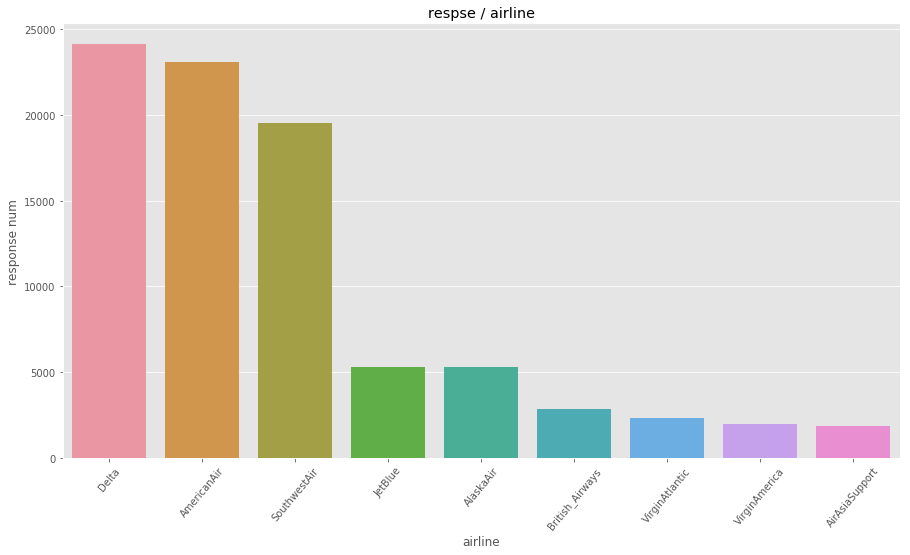

In [48]:
# Airline inquiry & response volume 
plt.figure(figsize = (15, 8))

sns.countplot(x = 'author_id_y',
             data = df, 
             order = df['author_id_y'].value_counts().index)

plt.xlabel('airline')
plt.ylabel('response num')
plt.title('respse / airline')
plt.xticks(rotation = 50);

In [49]:
# Results for airlines with fewer customer inquiries may be more extreme

    # Expect higher uncertainty for these airlines than those with larger volumes

In [50]:
# Model airlines using Negative binomial dist 

air_traces = {}

# CAT to INT 

pre = preprocessing.LabelEncoder()
air_idx = pre.fit_transform(df['author_id_y'])
air = pre.classes_
n_air = len(air) 

In [51]:
air

array(['AirAsiaSupport', 'AlaskaAir', 'AmericanAir', 'British_Airways',
       'Delta', 'JetBlue', 'SouthwestAir', 'VirginAmerica',
       'VirginAtlantic'], dtype=object)

In [52]:
for p in air:
    with pm.Model() as model_a:
        alpha = pm.Uniform('alpha', lower = 0, upper = 100)
        mu = pm.Uniform('mu', lower = 0, upper = 60)
        
        data = df[df['author_id_y'] == p]['res_time'].values
        
        est = pm.NegativeBinomial('est', mu = mu, alpha = alpha, observed = data)
        pred = pm.NegativeBinomial('pred', mu = mu, alpha = alpha)
        
        trace = pm.sample(2000, tune = 2000)
        
        air_traces[p] = trace

Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:12<00:00, 642.23draws/s]


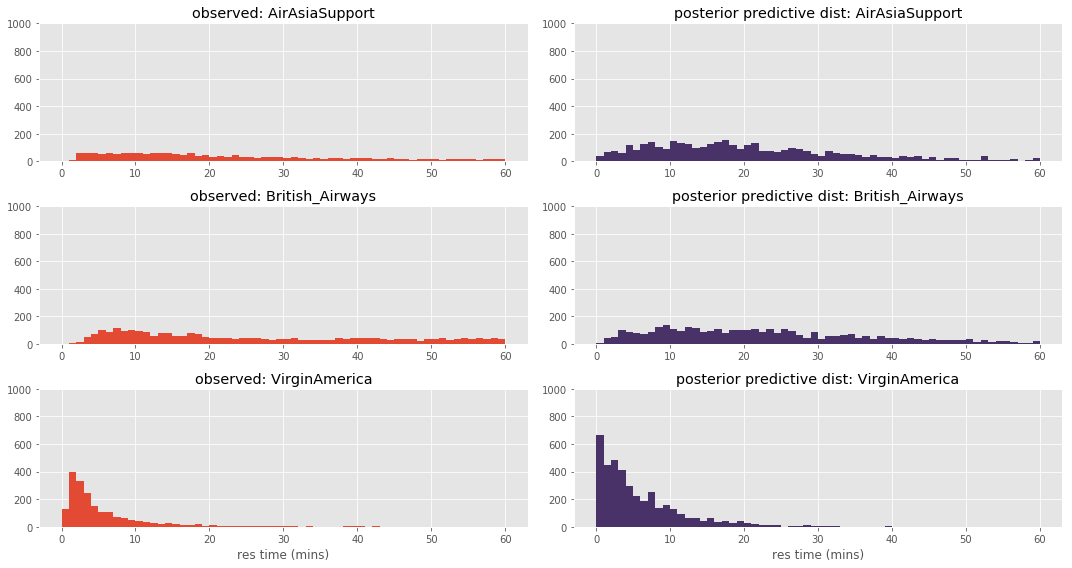

In [53]:
# Posterior predictive dist for airlines 

# Plot
fig, axs = plt.subplots(3, 2, 
                       figsize = (15, 8))

axs = axs.ravel()
y_left_max = 1000
y_right_max = 1000
x_lim = 60
ix = [0, 3, 7]

for i, j, p in zip([0, 1, 2], [0, 2, 4], air[ix]):
    axs[j].set_title('observed: %s' % p)
    axs[j].hist(df[df['author_id_y'] == p]['res_time'].values,
               range = [0, x_lim], 
               bins = x_lim,
               histtype = 'bar')
    axs[j].set_ylim([0, y_left_max])
    
for i, j, p in zip([0, 1, 2], [1, 3, 5], air[ix]):
    axs[j].set_title('posterior predictive dist: %s' % p)
    axs[j].hist(air_traces[p].get_values('pred'),
                     range = [0, x_lim],
                     bins = x_lim,
                     histtype = 'bar',
                     color = colors[1])
    axs[j].set_ylim([0, y_right_max])
    
axs[4].set_xlabel('res time (mins)')
axs[5].set_xlabel('res time (mins)')

plt.tight_layout()

In [54]:
# AirAsia different 
    # Indicate AA takes longer to respond than others 
        # or incomplete small sample extreme results 
            # relative to VA / BA

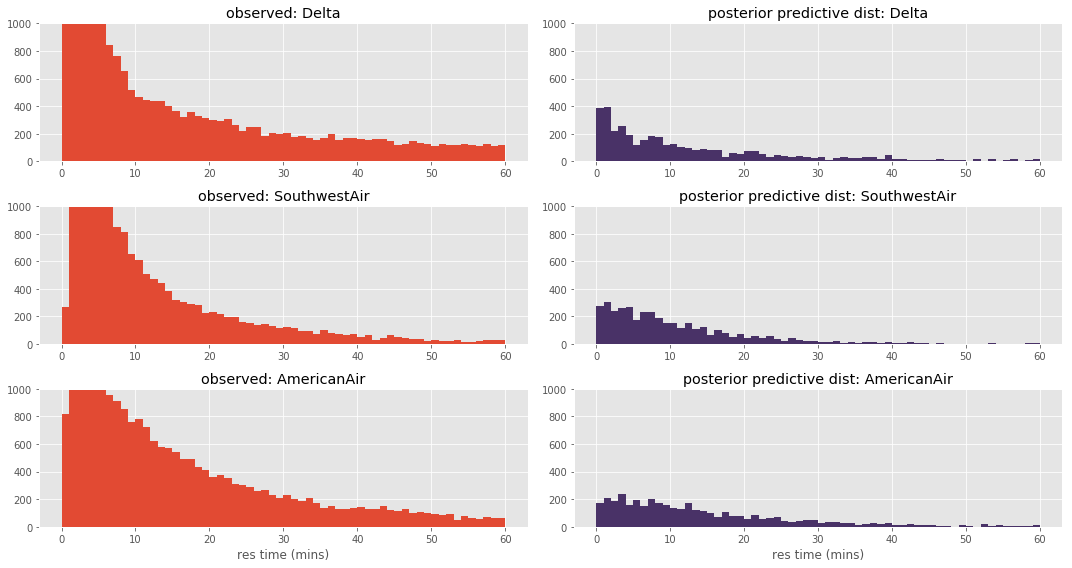

In [55]:
fig, axs = plt.subplots(3, 2, 
                       figsize = (15, 8))

axs = axs.ravel()
y_left_max = 1000
y_right_max = 1000
x_lim = 60
ix = [4, 6, 2]

for i, j, p in zip([0, 1, 2], [0, 2, 4], air[ix]):
    axs[j].set_title('observed: %s' % p)
    axs[j].hist(df[df['author_id_y'] == p]['res_time'].values,
               range = [0, x_lim], 
               bins = x_lim,
               histtype = 'bar')
    axs[j].set_ylim([0, y_left_max])
    
for i, j, p in zip([0, 1, 2], [1, 3, 5], air[ix]):
    axs[j].set_title('posterior predictive dist: %s' % p)
    axs[j].hist(air_traces[p].get_values('pred'),
                     range = [0, x_lim],
                     bins = x_lim,
                     histtype = 'bar',
                     color = colors[1])
    axs[j].set_ylim([0, y_right_max])
    
axs[4].set_xlabel('res time (mins)')
axs[5].set_xlabel('res time (mins)')

plt.tight_layout()

In [56]:
# Larger samples less extreme results 

# Posterior predictive dist does not very significantly 

In [57]:
# Multilevel / hierarchical regression 

df = df[['res_time', 'author_id_y', 'created_at_y_is_weekend', 'word_count']]
formula = 'response_time ~ ' + ' + '.join(['%s' % variable for variable in df.columns[1:]])

formula

'response_time ~ author_id_y + created_at_y_is_weekend + word_count'

In [58]:
# CAT to INT 
    
# Est baseline param for each airline's res_time

# Est other params across airline data

In [59]:
pre = preprocessing.LabelEncoder()
air_idx = pre.fit_transform(df['author_id_y'])
air = pre.classes_
n_air = len(air) 


with pm.Model() as model_h:
    intercept = pm.Normal('intercept', mu = 0, sd = 100, 
                         shape = n_air)
    
    slope_weekend = pm.Normal('slope_weekend', mu = 0, sd = 100)
    
    slope_word = pm.Normal('slope_word', mu = 0, sd = 100)

    mu = tt.exp(intercept[air_idx] 
                + slope_weekend*df.created_at_y_is_weekend 
                + slope_word*df.word_count)

    est = pm.Poisson('est', mu = mu, observed = df['res_time'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()

    trace = pm.sample(3500, step, start = start, progressbar = True)

/opt/conda/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -6.727e+05, ||grad|| = 1.0242e+05: 100%|██████████| 223/223 [00:02<00:00, 94.94it/s] 
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [02:23<00:00, 32.74draws/s]


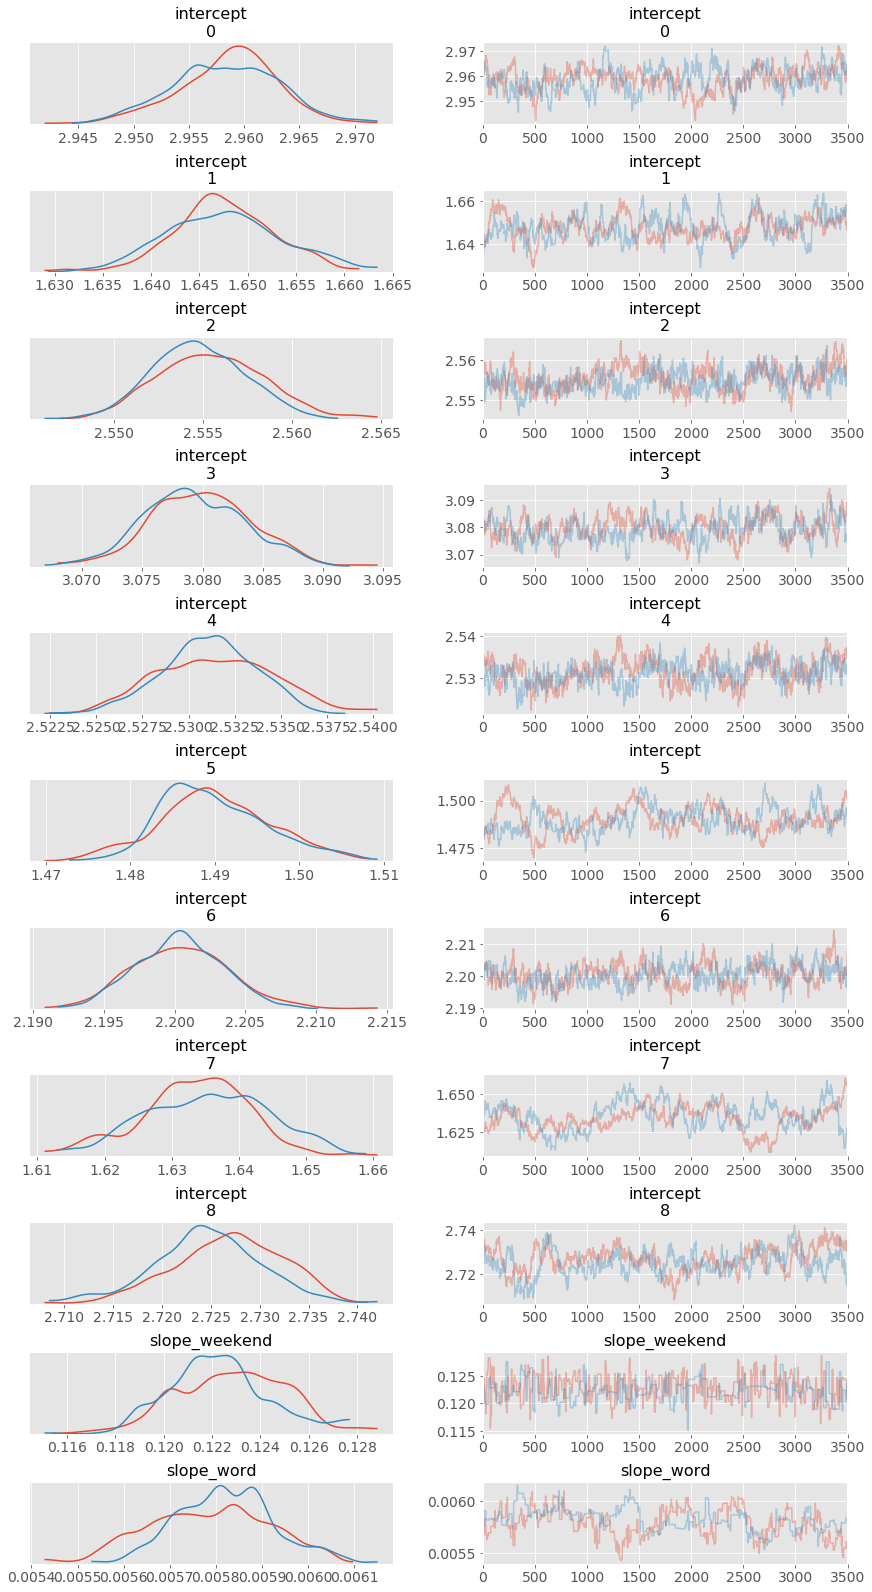

In [60]:
# MCMC

az.plot_trace(trace);

In [61]:
# Most likely param value for each airline.
    # param = Beta 
        # Beta informs if and how weekend and word count increases res_time 

# Weekend inquiries increases res_time marginally

# Greater word count increases res_time marginally 

# Baseline res_time varies for each airline 

# Hierarchical model estimates Beta for every airline 

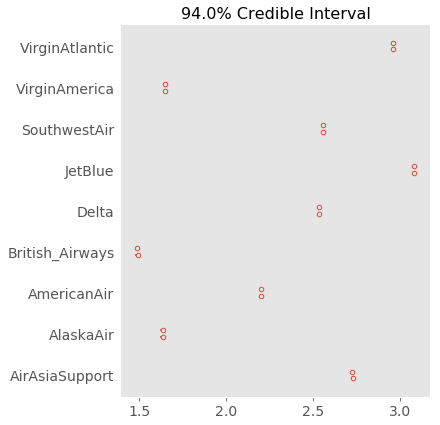

In [62]:
# Plot 94% credible interval for each airline's param 
    # Most likely param value (intercept)

_, ax = pm.forestplot(trace, var_names = ['intercept'])
ax[0].set_yticklabels(air.tolist());

In [63]:
# Model has ittle uncertainty for each airline 

In [64]:
# R2 

ppc = pm.sample_posterior_predictive(trace, samples = 2000,
                                    model = model_h)

az.r2_score(df.res_time.values, ppc['est'])

/opt/conda/lib/python3.6/site-packages/pymc3/sampling.py:1108: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:40<00:00, 48.93it/s]


r2        0.612443
r2_std    0.085691
dtype: float64